In [4]:
import numpy as np
from joblib import load
from pathlib import Path
from xspec import AllModels, AllData, Model, Plot
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

from modules.network import r_squared

In [5]:
# Set up paths for logs and models
cwd = Path.cwd()
path_to_logs = Path(cwd / "logs")
path_to_samples = Path(cwd / "samples")

fluxes = []

model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"

sample_scaled = np.load(path_to_samples / 'complete_sample.npy')
relevant_par =  np.load(path_to_samples / "relevant_par.npy")

# Invert the log10 of these components
log_index = [0, 9, 12]
for i in range(sample_scaled.shape[0]):
    for j in log_index:
        sample_scaled[i, j] =  pow(10, sample_scaled[i, j])
        
# Iterate through scaled samples to set up and save models
for index, params in enumerate(sample_scaled):
    
    # Clear existing XSPEC models and data
    AllModels.clear()
    AllData.clear()
    AllData.dummyrsp(0.5, 20.)

    # Initialize the model
    m = Model(model_name)

    # Changing default frozen parameters to unfrozen
    m.rdblur.Betor10.frozen = False
    m.rdblur.Rout_M.frozen = True
    m.rdblur.Rin_M.frozen = False
    m.rfxconv.Fe_abund.frozen = False
    m.comptb.gamma.frozen = True
    m.comptb.delta.frozen = True
    m.comptb.log_A.frozen = True

    m.rdblur.Rout_M.values = 1000
    m.comptb.delta.values = 0
    m.comptb.log_A.values = 8

    m.rfxconv.cosIncl.link = "COSD(5)"
    # Linking comptb_6 (refletion) parameters to comptb (comptb)
    start = 20  # Number of the first parameter of comptb_6
    for i in range(start, start + len(m.comptb_6.parameterNames)):
        m(i).link = str(i-9) # 9 is the separation between comptb and comptb_6

    # Add the model to the spectral analysis system and set parameters
    AllModels.setPars(m, {int(relevant_par[j]):params[j] for j in range(len(relevant_par))})

    # Set up the energy range of interest for plotting
    Plot.device = "/null"
    Plot.xAxis = "keV"
    Plot.show()
    Plot('model')
    energy = Plot.x()
    flux = Plot.model()
    fluxes.append(flux)


Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      frozen
   9    3   rfxconv    cosIncl             0.500000     frozen
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000      +/-  0.0          
  12    4   comptb     gamma               3.00000      frozen
  13    4   comptb     al

In [6]:
data = 'models_0.5-20_100k'
cwd = Path.cwd()
path_to_logs = cwd / 'logs'
path_to_data = cwd / 'data' / data
path_to_results = cwd / 'results'
result_dir = path_to_results / 'ANN' / '100k' / 'batchnorm' / 'drop_0.3' /'lr_1e-4' / '256x4_500e'
model_file_path = result_dir / 'ANN_model.h5'

# Load the model
model = load_model(model_file_path, custom_objects={'r_squared': r_squared})
# Load the saved scaler
flux_scaler = load(path_to_data / 'flux_scaler.joblib')
predicted = []

for par in sample_scaled:
    # Make predictions
    log_index = [0, 9, 12]
    for i in log_index:
        par[i] = np.log10(par[i])
    prediction = model.predict(par.reshape(-1, par.shape[0]))
    flux_predicted = flux_scaler.inverse_transform(prediction)
    predicted.append(flux_predicted)
    

2024-02-13 23:45:56.272458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-13 23:45:56.294850: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


In [7]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               3584      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)              

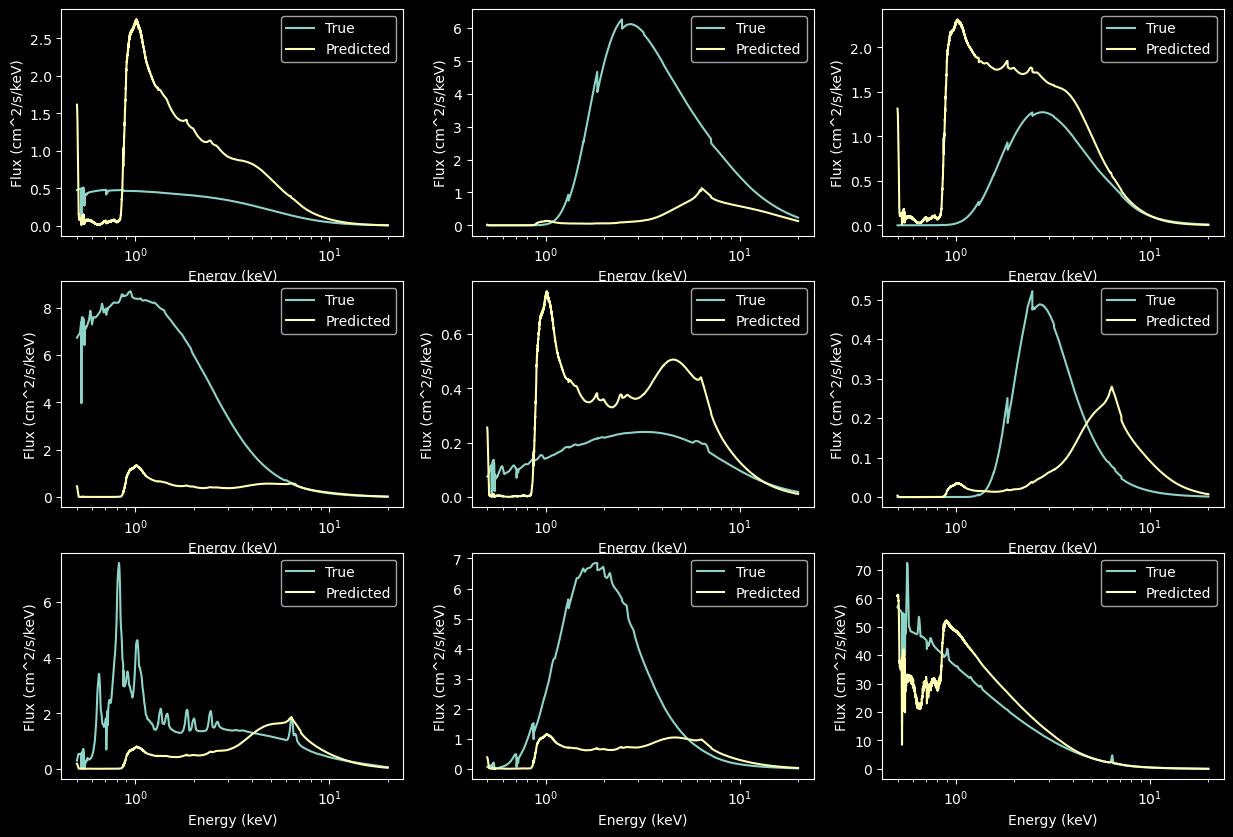

In [9]:
n_points = None
# Create subplots for the selected number of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for idx, true_flux in enumerate(fluxes):
    
    # Calculate the row and column index for the subplot
    row_index = idx // 3
    col_index = idx % 3
    
    if n_points:
        energy_reshape = (np.array(energy).reshape(-1, n_points).mean(axis=1)).tolist()
        true_flux_reshape = (np.array(true_flux).reshape(-1, n_points).mean(axis=1)).tolist()
    else:
        energy_reshape = energy
        true_flux_reshape = true_flux
    # Plot the data on the corresponding subplot
    axes[row_index, col_index].plot(energy_reshape, true_flux_reshape, label="True")
    axes[row_index, col_index].plot(energy_reshape, predicted[idx][0], label='Predicted')
    axes[row_index, col_index].set_xlabel('Energy (keV)')
    axes[row_index, col_index].set_xscale('log')
    axes[row_index, col_index].set_ylabel('Flux (cm^2/s/keV)')
    axes[row_index, col_index].legend()